# Let's make some Analytics to the data base.

I would like to know which **location** has most job offers.

In [28]:
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot
import seaborn as sns
import numpy as np
import sqlite3

In [29]:
# make the connection to the DB
conn = sqlite3.connect("../data/offers.db")

# create data frame
sql = pd.read_sql_query("SELECT * FROM offers", conn)
df = pd.DataFrame(sql, columns=["id", "company", "job", "locate", "url", "date"])

df.head()

,id,company,job,locate,url,date
0,1,Dexian Inc,Entry Level Data Engineering,"Houston, TX",https://www.linkedin.com/jobs/view/entry-level...,2024-03-24
1,2,Planned Systems International,Jr Web Developer (Entry Level),United States,https://www.linkedin.com/jobs/view/jr-web-deve...,2024-03-25
2,3,Medasource,Data Analyst,New York City Metropolitan Area,https://www.linkedin.com/jobs/view/data-analys...,2024-03-25
3,4,Get It Recruit - Information Technology,Junior Software Developer - Remote | WFH,"Mount Laurel, NJ",https://www.linkedin.com/jobs/view/junior-soft...,2024-03-25
4,5,Dexian Inc,Junior Backend Engineer,"Autaugaville, AL",https://www.linkedin.com/jobs/view/junior-back...,2024-03-24


Explore the data a little:

In [30]:
df.shape

(1042, 6)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1042 non-null   int64 
 1   company  1042 non-null   object
 2   job      1042 non-null   object
 3   locate   1042 non-null   object
 4   url      1042 non-null   object
 5   date     1042 non-null   object
dtypes: int64(1), object(5)
memory usage: 49.0+ KB


In [32]:
print(df.isnull().sum())

id         0
company    0
job        0
locate     0
url        0
date       0
dtype: int64


In [33]:
df.duplicated().sum()

0

In [34]:
df.describe(include=['object'])

,company,job,locate,url,date
count,1042,1042,1042,1042,1042
unique,191,239,122,556,9
top,Patterned Learning Career,Junior Python Django Developer,United States,https://www.linkedin.com/jobs/view/entry-level...,2024-03-25
freq,163,47,223,6,279


The location data that is most repeated (top) is `United States`, but that is the default location when performing the scraping process. 

Les't see more information about `locate` columm:

In [35]:
df['locate'].head()

0                        Houston, TX
1                      United States
2    New York City Metropolitan Area
3                   Mount Laurel, NJ
4                   Autaugaville, AL
Name: locate, dtype: object

In [36]:
location = df['locate'].value_counts().to_frame()
location

,count
locate,
United States,223
"New York, NY",95
"Boston, MA",77
"Los Angeles, CA",56
"Houston, TX",50
...,...
"San Mateo, CA",1
Greater Pittsburgh Region,1
"Fayetteville, AR",1


There are rows with `United States`, just the name like `New York City Metropolitan Area` / `Greater Pittsburgh Region` and the city - state abbreviation like `Houston, TX` / `New York, NY`.

I would like to only have the abbreviation of the state to know in general which of them has most offers.

In [37]:
# create a new DF without the `United States` rows
new_df = df.loc[(df['locate'] != "United States")]

# create a new column with the state abbreviation called `state_code`
new_df['state_code'] = new_df['locate'].str.split(',').str[1].str.strip()

C:\Users\jv_aa\AppData\Local\Temp\ipykernel_24480\184181021.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['state_code'] = new_df['locate'].str.split(',').str[1].str.strip()


In [38]:
new_df.head()

,id,company,job,locate,url,date,state_code
0,1,Dexian Inc,Entry Level Data Engineering,"Houston, TX",https://www.linkedin.com/jobs/view/entry-level...,2024-03-24,TX
2,3,Medasource,Data Analyst,New York City Metropolitan Area,https://www.linkedin.com/jobs/view/data-analys...,2024-03-25,NaN
3,4,Get It Recruit - Information Technology,Junior Software Developer - Remote | WFH,"Mount Laurel, NJ",https://www.linkedin.com/jobs/view/junior-soft...,2024-03-25,NJ
4,5,Dexian Inc,Junior Backend Engineer,"Autaugaville, AL",https://www.linkedin.com/jobs/view/junior-back...,2024-03-24,AL
5,6,HireMeFast LLC,Data Scientist Entry Level,"Fort Smith, AR",https://www.linkedin.com/jobs/view/data-scient...,2024-03-24,AR


It seems that now, the `state_code` column has NaN value.

In [39]:
new_df.shape

(819, 7)

In [40]:
print(new_df.isnull().sum())

id             0
company        0
job            0
locate         0
url            0
date           0
state_code    14
dtype: int64


Because its just 14 rows with NaN value, I going to eliminate it.

In [41]:
# eliminate nan value
new_df.dropna(subset=["state_code"], axis=0, inplace=True)

# drop the `locate` columm because I going to use the `state_code`
new_df.drop("locate", axis=1, inplace=True)

# reset table index
new_df.reset_index(drop=True, inplace=True)

C:\Users\jv_aa\AppData\Local\Temp\ipykernel_24480\3574703595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.dropna(subset=["state_code"], axis=0, inplace=True)
C:\Users\jv_aa\AppData\Local\Temp\ipykernel_24480\3574703595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop("locate", axis=1, inplace=True)


In [42]:
print(new_df.isnull().sum())

id            0
company       0
job           0
url           0
date          0
state_code    0
dtype: int64


In [43]:
new_df.shape

(805, 6)

In [44]:
new_df.describe(include=['object'])

,company,job,url,date,state_code
count,805,805,805,805,805
unique,84,145,408,9,37
top,Patterned Learning Career,Junior Python Django Developer,https://www.linkedin.com/jobs/view/entry-level...,2024-03-31,NY
freq,163,47,6,248,115


Now the value that is most repeated is `NY`. Let's confirm it:

In [45]:
states = new_df['state_code'].value_counts().to_frame()
states

,count
state_code,
NY,115
CA,92
TX,81
MA,81
AZ,45
MI,43
AR,39
AK,34
United States,33


There are still columns with the `United States` value.

In [46]:
new_df = new_df.loc[(new_df['state_code'] != "United States")]
new_df.reset_index(drop=True, inplace=True)

In [47]:
states = new_df['state_code'].value_counts().to_frame()
states

,count
state_code,
NY,115
CA,92
TX,81
MA,81
AZ,45
MI,43
AR,39
AK,34
FL,32


And now represent this data on a graph:

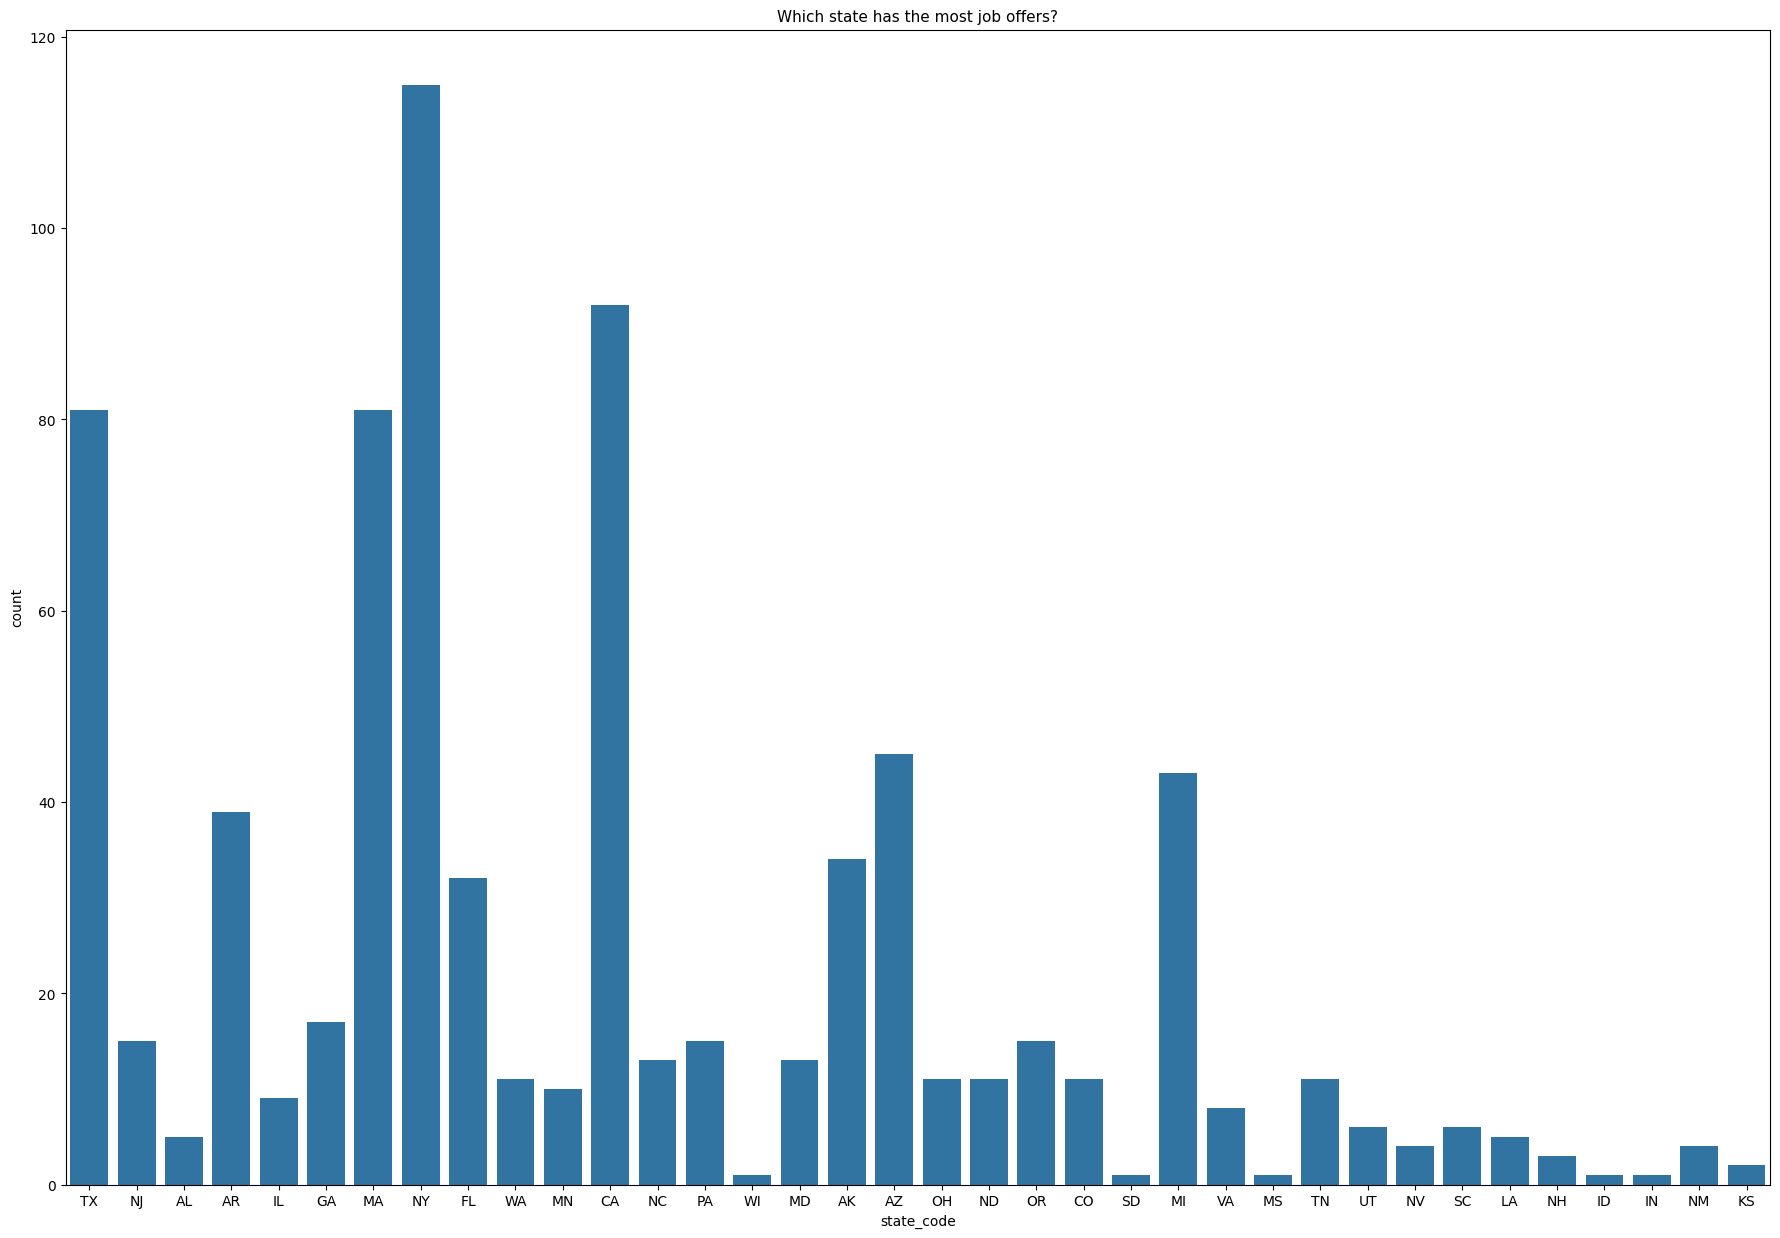

In [48]:
pyplot.figure(figsize=(20, 15))
pyplot.subplot(1, 2, 2)
sns.countplot(data = new_df, x = 'state_code')
pyplot.title('Which state has the most job offers?', size=11)
pyplot.subplots_adjust(right=2)
pyplot.show()

Now you can clearly see the states with the most job offers are:

1. New York, NY.
2. California, CA.
3. Texas, TX and Massachusetts, MA.